In [1]:
import simbench as sb
import numpy as np
import pandapower.networks as pn
from sklearn.cluster import k_means
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pandapower as pp

/Users/alfred/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def initialise_grid():
    LOAD_MAGNIFICATION_FACTOR = 2.5
    net = pn.case30()
    net.load['p_mw'] = net.load['p_mw'] * LOAD_MAGNIFICATION_FACTOR
    net.line['max_i_ka'] = net.line['max_i_ka'] * LOAD_MAGNIFICATION_FACTOR * 100

    net.poly_cost.loc[0, 'cp1_eur_per_mw'] = 4
    net.poly_cost.loc[0, 'cp2_eur_per_mw2'] = 0.05
    
    # net.poly_cost.loc[2, 'cp2_eur_per_mw2'] = 0.01  # attention

    wind_num = 1
    pv_num = 2
    wind_poses = [2]
    pv_poses = [3, 5]
    # pv_poses = [3, 4, 5, 6]     # To be modified...

    for wind_pos in wind_poses:
        pp.create_sgen(net, wind_pos, 100,     # To be modified...
                       type='Wind_MV', controllable=False)
    for pv_pos in pv_poses:
        pp.create_sgen(net, pv_pos, 20,
                       type='PV_MV', controllable=False)

    load_profile_belonging = ['G0-A',
                              'G0-A',
                              'G3-A',
                              'G3-A',
                              'G3-H',
                              'G3-H',
                              'G4-A',
                              'G4-A',
                              'G5-A',
                              'G5-A',
                              'L2-M',
                              'L2-M',
                              'G0-M',
                              'G0-M',
                              'G1-A',
                              'G1-A',
                              'G1-B',
                              'G1-B',
                              'G1-C',
                              'G1-C']

    net.load['profile'] = load_profile_belonging
    net.sgen['profile'] = ['WP1', 'PV3', 'PV4']     # To be modified...
    # net.sgen['profile'] = ['WP1', 'PV1', 'PV2', 'PV3', 'PV4']
    
    net.ext_grid['max_p_mw'] = 800
    net.ext_grid['min_p_mw'] = -400

    return net

net = initialise_grid()
net_load_max = net.load['p_mw']
net_sgen_max = net.sgen['p_mw']

In [26]:
with open('typical_scenario.txt', 'rb') as file:
    typical_scenarios = pickle.load(file)
    
# with open('all_scenarios_dataset.txt', 'rb') as file:
#     typical_scenarios = pickle.load(file)

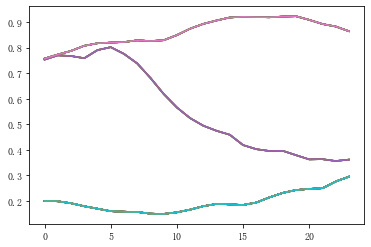

In [13]:
for i in range(50):
    plt.plot(typical_scenarios[i]['WP1'])

In [4]:
len(typical_scenarios)

50

In [27]:
def update_value(net, profile, time_step):
    for i in range(net.load.shape[0]):
        net.load.loc[i, 'p_mw'] = profile.loc[time_step, net.load.loc[i]['profile']] * net_load_max[i]
        
    for i in range(net.sgen.shape[0]):
        net.sgen.loc[i, 'p_mw'] = profile.loc[time_step, net.sgen.loc[i]['profile']] * net_sgen_max[i]

In [65]:
gen_logger.sum(axis=0).shape

(24,)

iter:  2


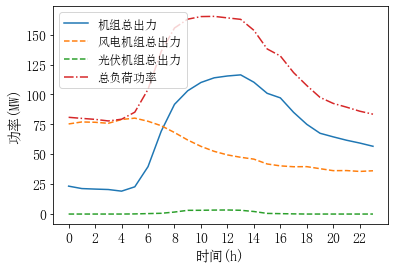

In [54]:
avg_cost = []
fail_times = 0

j = 2

print('iter: ', j)
net = initialise_grid()
cost = 0
gen_logger = []
sgen_logger = []
ext_grid_logger = []
load_logger = []
for t in range(24):
    update_value(net, typical_scenarios[j], t)
    # print(net.load['p_mw'].sum())
    # print(net.sgen)
    try:
        pp.rundcopp(net)
        # print(net.res_ext_grid)
        gen_logger.append(net.res_gen['p_mw'].values)
        sgen_logger.append(net.res_sgen['p_mw'].values)
        ext_grid_logger.append(net.res_ext_grid['p_mw'].values)
        load_logger.append(net.load['p_mw'].sum())
    except BaseException as exp:
        fail_times += 1
        print('failed')
        print(net.load['p_mw'].sum())
        print(net.sgen)
        break
    # print('success')

    cost += net.res_cost

# avg_cost.append(cost)
gen_logger = np.array(gen_logger).transpose().sum(axis=0)
sgen_logger = np.array(sgen_logger).transpose()
sgen_logger_wind = sgen_logger[0, :]
sgen_logger_pv = sgen_logger[1:, :].sum(axis=0)
fig, ax = plt.subplots()
  
ax.plot(gen_logger, label='机组总出力')
ax.plot(sgen_logger_wind, '--', label = '风电机组总出力')
ax.plot(sgen_logger_pv, '--', label = '光伏机组总出力')
ax.plot(load_logger, '-.', label = '总负荷功率')
        

# ext_grid_logger = [0] * 24
# ax.plot(ext_grid_logger, '*', label='外部电网输入功率')
        
plt.legend()

plt.legend(fontsize=12)
plt.xticks(ticks=range(0,24,2), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(u'时间(h)', fontsize=14)
plt.ylabel(u'功率(MW)', fontsize=14)
plt.savefig('场景对比风电', dpi=300, bbox_inches='tight')

# np.mean(avg_cost)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_xlabel_grp',
 '_align_ylabel_grp',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_constrained',
 '_constrained_layout_pads',
 '_contains',
 '_dpi',
 '_gci',
 '_get_axes',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_layoutbox',
 '_make_key',
 '_mouseover',
 '_oid',
 '_path_effects',
 '_picker',
 '_process_projection_requirements',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_ax',
 '_remove_method',
 '_repr_html_',
 '_set

28,29

In [7]:
# avg_cost = []
# fail_times = 0
# for j in range(len(typical_scenarios)):
#     print('iter: ', j)
#     net = initialise_grid()
#     cost = 0
#     for t in range(24):
#         update_value(net, typical_scenarios[j], t)
#         # print(net.load['p_mw'].sum())
#         # print(net.sgen)
#         try:
#             pp.rundcopp(net)
#             print(net.res_ext_grid)
#         except BaseException as exp:
#             fail_times += 1
#             print('failed')
#             print(net.load['p_mw'].sum())
#             print(net.sgen)
#             break
#         # print('success')

#         cost += net.res_cost
        
#     avg_cost.append(cost)
    
# np.mean(avg_cost)

In [8]:
# cost / 24

方案1 + 典型场景：8850.835099104905

方案1 + 随机场景：7316.838560865415    20 fails

方案2 + 典型场景：10530.63710644616

方案2 + 随机场景：9293.473650630587   11 fails


In [9]:
7832.262 * 1.015

7949.745929999999

方案1 + 全场景：6473.853749653268

方案1 + 典型场景：6242.215870626957

方案1 + 随机场景：7280.584135592549

方案2 + 全场景：8285.223498088346

方案2 + 典型场景：7832.261526287449

方案2 + 随机场景：8650.020884526177